In [ ]:
!pip install torch fsspec==2025.3.2 datasets optuna plotly

INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0

In [ ]:
import re
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import load_from_disk  # O si ya lo tienes en memoria, omite esta línea
import optuna
import json, os
from torch.utils.data import DataLoader

In [ ]:
data_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_valid_en"   # Archivo CSV con tu dataset de problemas matemáticos
tokens_path = "/content/drive/MyDrive/tesis/categorizacion/tokens.pkl"
labels_path = "/content/drive/MyDrive/tesis/categorizacion/labels.pkl"
problem_type_encoder_path = "/content/drive/MyDrive/tesis/categorizacion/problem_type_encoder.pkl"
question_type_encoder_path = "/content/drive/MyDrive/tesis/categorizacion/question_type_encoder.pkl"
prepared_data_path = "/content/drive/MyDrive/tesis/categorizacion/prepared_dataset"
model_path = "/content/drive/MyDrive/tesis/categorizacion/bert_pre_trained_math.pth"
best_hyperparams_path = "/content/drive/MyDrive/tesis/categorizacion/best_hyperparams.json"
text_col_name = "problem"  # Columna con el texto del problema

In [ ]:
def preprocess_function(example, tokenizer, seq_len):
    text = example["problem"].lower()
    # Conservar operadores y puntuación matemática relevante
    text = re.sub(r"[^\w\d\s\+\-\*/=^√%.,()]", " ", text)
    # Normalizar repeticiones de 'x' largas
    text = re.sub(r'\b[x]{2,}\b', 'x', text)
    text = re.sub(' +', ' ', text)

    tokens = tokenizer(text, padding="max_length", max_length=seq_len, truncation=True)
    return tokens

# Funciones para guardar y cargar objetos con pickle
def save_file(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    return pickle.load(open(name, "rb"))

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
seq_len = 512  # Ajusta según lo necesites

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Preparacion del dataset

In [ ]:
ds = load_from_disk(data_path)  # Asegúrate de que la ruta corresponde a tu dataset
print(ds)


Dataset({
    features: ['problem', 'solution', 'answer', 'problem_type', 'question_type', 'problem_is_valid', 'solution_is_valid', 'source', 'synthetic'],
    num_rows: 452305
})


In [ ]:
cols_to_remove = ['solution', 'answer', 'problem_is_valid', 'solution_is_valid', 'source', 'synthetic']
ds = ds.remove_columns(cols_to_remove)
print(ds)

Dataset({
    features: ['problem', 'problem_type', 'question_type'],
    num_rows: 452305
})


In [ ]:
# Analiza las longitudes de input_ids en el dataset de entrenamiento
lengths = [len(example["problem"]) for example in ds]

# Estadísticas
max_len = max(lengths)
mean_len = int(np.mean(lengths))
p95 = int(np.percentile(lengths, 95))
p99 = int(np.percentile(lengths, 99))

print(f"Max length: {max_len}")
print(f"Mean length: {mean_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

Max length: 7479
Mean length: 283
95th percentile: 619
99th percentile: 1000


In [ ]:
ds = ds.map(lambda example: preprocess_function(example, tokenizer, seq_len), batched=False)

Map:   0%|          | 0/452305 [00:00<?, ? examples/s]

In [ ]:
print(ds)
print(ds.features)
print(len(ds))
print(ds[0])

Dataset({
    features: ['problem', 'problem_type', 'question_type', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 452305
})
{'problem': Value(dtype='string', id=None), 'problem_type': Value(dtype='string', id=None), 'question_type': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
452305
{'problem': '\nProblem 1. Find all prime numbers $p$ for which there exist positive integers $x, y$ and $z$ such that the number\n\n$$\nx^{p}+y^{p}+z^{p}-x-y-z\n$$\n\nis a product of exactly three distinct prime numbers.\n', 'problem_type': 'Number Theory', 'question_type': 'math-word-problem', 'input_ids': [101, 2463, 122, 119, 1525, 1155, 5748, 2849, 185, 1111, 1134, 1175, 4056, 3112, 27264, 193, 117, 194, 1105, 195, 1216, 1115, 1103, 1295, 193, 167

In [ ]:
le_problem_type = LabelEncoder()
le_question_type = LabelEncoder()

ds = ds.add_column(
    "problem_type_label", le_problem_type.fit_transform(ds["problem_type"])
)
ds = ds.add_column(
    "question_type_label", le_question_type.fit_transform(ds["question_type"])
)



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


In [ ]:
# Guardar codificadores y dataset procesado
save_file(problem_type_encoder_path, le_problem_type)
save_file(question_type_encoder_path, le_question_type)
ds.save_to_disk(prepared_data_path)

Saving the dataset (0/4 shards):   0%|          | 0/452305 [00:00<?, ? examples/s]

### Entrenamiento

In [ ]:
ds = load_from_disk("file://" + prepared_data_path)
print(ds)
# Opcional: guarda los codificadores
le_problem_type = load_file(problem_type_encoder_path)
le_question_type = load_file(question_type_encoder_path)


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['problem', 'problem_type', 'question_type', 'input_ids', 'token_type_ids', 'attention_mask', 'problem_type_label', 'question_type_label'],
    num_rows: 452305
})


In [ ]:
num_problem_types = len(le_problem_type.classes_)
num_question_types = len(le_question_type.classes_)

In [ ]:
ds = ds.train_test_split(test_size=0.2)
ds["validation"] = ds["test"].train_test_split(test_size=0.5)["test"]
ds["train"] = ds["train"]
ds["test"] = ds["test"]

print(ds)
print(ds["train"].features)
print(ds["validation"].features)
print(ds["test"].features)
print(len(ds["train"]))
print(len(ds["validation"]))
print(len(ds["test"]))

DatasetDict({
    train: Dataset({
        features: ['problem', 'problem_type', 'question_type', 'input_ids', 'token_type_ids', 'attention_mask', 'problem_type_label', 'question_type_label'],
        num_rows: 361844
    })
    test: Dataset({
        features: ['problem', 'problem_type', 'question_type', 'input_ids', 'token_type_ids', 'attention_mask', 'problem_type_label', 'question_type_label'],
        num_rows: 90461
    })
    validation: Dataset({
        features: ['problem', 'problem_type', 'question_type', 'input_ids', 'token_type_ids', 'attention_mask', 'problem_type_label', 'question_type_label'],
        num_rows: 45231
    })
})
{'problem': Value(dtype='string', id=None), 'problem_type': Value(dtype='string', id=None), 'question_type': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Valu

In [ ]:
# Analiza las longitudes de input_ids en el dataset de entrenamiento
lengths = [len(example["input_ids"]) for example in ds["train"]]

# Estadísticas
max_len = max(lengths)
mean_len = int(np.mean(lengths))
p95 = int(np.percentile(lengths, 95))
p99 = int(np.percentile(lengths, 99))

print(f"Max length: {max_len}")
print(f"Mean length: {mean_len}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")


Max length: 512
Mean length: 512
95th percentile: 512
99th percentile: 512


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Extrae los tensores generados por el tokenizer
        tokens = {
            "input_ids": torch.tensor(item["input_ids"]),
            "attention_mask": torch.tensor(item["attention_mask"])
        }
        # Extrae las etiquetas
        problem_label = torch.tensor(item["problem_type_label"])
        question_label = torch.tensor(item["question_type_label"])
        return tokens, problem_label, question_label



In [ ]:
train_dataset = TextDataset(ds["train"])
valid_dataset = TextDataset(ds["validation"])
test_dataset = TextDataset(ds["test"])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
!pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 43.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BertMultiTaskClassifier(nn.Module):
    def __init__(self, dropout, num_problem_types, num_question_types):
        super(BertMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        # Congelar los parámetros inicialmente (para entrenar solo los cabezales)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.classifier_problem = nn.Linear(768, num_problem_types)
        self.classifier_question = nn.Linear(768, num_question_types)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]  # CLS token output
        x = self.dropout(pooled_output)
        x = self.activation(x)
        logits_problem = self.classifier_problem(x)
        logits_question = self.classifier_question(x)
        return logits_problem, logits_question

    def unfreeze_bert_layers(self, num_layers=2):
        """
        Descongela las últimas `num_layers` de BERT para fine-tuning.
        """
        # Suponiendo que BERT tiene 12 capas (como en bert-base-cased)
        for i, layer in enumerate(self.bert.encoder.layer[-num_layers:]):
            for param in layer.parameters():
                param.requires_grad = True


### Entrenamiento basado en valid_lost

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

def train(train_loader, valid_loader, model, criterion, optimizer, device, num_epochs, model_path, unfreeze_after_epoch=1, patience = 3):
    best_loss = float('inf')
    epochs_without_improvement = 0
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

    # Opcional: para utilizar precisión mixta (FP16)
    #scaler = torch.cuda.amp.GradScaler()
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}")
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            tokens_batch, labels_problem, labels_question = batch
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            optimizer.zero_grad()

            # Usar autocast para FP16 (si la GPU lo soporta)
            #with torch.cuda.amp.autocast():
            with torch.amp.autocast('cuda'):
                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_losses.append(loss.item())

        # Opción: Hacer gradual unfreezing después de una cierta época
        if epoch + 1 == unfreeze_after_epoch:
            print("Descongelando las últimas 2 capas de BERT para fine-tuning.")
            model.unfreeze_bert_layers(num_layers=2)
            # Es recomendable reinicializar el optimizador tras cambiar los parámetros entrenables.
            optimizer = torch.optim.AdamW(model.parameters(), lr=optimizer.param_groups[0]['lr'])
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

        avg_train_loss = np.mean(train_losses)

        # Evaluación en validación
        valid_losses = []
        all_preds_problem, all_labels_problem = [], []
        all_preds_question, all_labels_question = [], []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                tokens_batch, labels_problem, labels_question = batch
                input_ids = tokens_batch["input_ids"].to(device)
                attention_mask = tokens_batch["attention_mask"].to(device)
                labels_problem = labels_problem.to(device)
                labels_question = labels_question.to(device)

                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question
                valid_losses.append(loss.item())

                preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
                preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
                all_preds_problem.extend(preds_problem)
                all_preds_question.extend(preds_question)
                all_labels_problem.extend(labels_problem.cpu().numpy())
                all_labels_question.extend(labels_question.cpu().numpy())

        avg_valid_loss = np.mean(valid_losses)
        f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
        f1_question = f1_score(all_labels_question, all_preds_question, average='macro')

        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
        print(f"Validation F1 - Problem: {f1_problem:.4f}, Question: {f1_question:.4f}")

        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            epochs_without_improvement = 0  # reinicia el contador
            torch.save(model.state_dict(), model_path)
            print(f"Modelo guardado con valid_loss: {best_loss:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No hubo mejora en valid_loss. Conteo: {epochs_without_improvement}/{patience}")
            if epochs_without_improvement >= patience:
                print("Early stopping activado. No hay mejora en validación.")
                break

### Entrenamiento basado en F1-score

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

def train(train_loader, valid_loader, model, criterion, optimizer, device, num_epochs, model_path, unfreeze_after_epoch=1, patience=3):
    best_f1 = 0.0
    epochs_without_improvement = 0
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}")
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            tokens_batch, labels_problem, labels_question = batch
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_losses.append(loss.item())

        # Unfreezing opcional
        if epoch + 1 == unfreeze_after_epoch:
            print("Descongelando las últimas 2 capas de BERT para fine-tuning.")
            model.unfreeze_bert_layers(num_layers=2)
            # Reconfigura el optimizador y scheduler con los nuevos parámetros entrenables,
            # pero sin sobrescribir el optimizador original
            for param_group in optimizer.param_groups:
                param_group['params'] = list(model.parameters())
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * total_steps),
                num_training_steps=total_steps
            )

        avg_train_loss = np.mean(train_losses)

        # Evaluación
        valid_losses = []
        all_preds_problem, all_labels_problem = [], []
        all_preds_question, all_labels_question = [], []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_loader):
                tokens_batch, labels_problem, labels_question = batch
                input_ids = tokens_batch["input_ids"].to(device)
                attention_mask = tokens_batch["attention_mask"].to(device)
                labels_problem = labels_problem.to(device)
                labels_question = labels_question.to(device)

                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question
                valid_losses.append(loss.item())

                preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
                preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
                all_preds_problem.extend(preds_problem)
                all_preds_question.extend(preds_question)
                all_labels_problem.extend(labels_problem.cpu().numpy())
                all_labels_question.extend(labels_question.cpu().numpy())

        avg_valid_loss = np.mean(valid_losses)
        f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
        f1_question = f1_score(all_labels_question, all_preds_question, average='macro')
        avg_f1 = (f1_problem + f1_question) / 2

        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
        print(f"Validation F1 - Problem: {f1_problem:.4f}, Question: {f1_question:.4f}, Average F1: {avg_f1:.4f}")

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            epochs_without_improvement = 0
            torch.save(model.state_dict(), model_path)
            print(f"Modelo guardado con F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No hubo mejora en F1. Conteo: {epochs_without_improvement}/{patience}")
            if epochs_without_improvement >= patience:
                print("Early stopping activado. No hay mejora en F1.")
                break


In [ ]:
def test(test_loader, model, criterion, device):
    model.eval()
    test_losses = []
    all_preds_problem, all_labels_problem = [], []
    all_preds_question, all_labels_question = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            tokens_batch, labels_problem, labels_question = batch
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            logits_problem, logits_question = model(input_ids, attention_mask)
            loss_problem = criterion(logits_problem, labels_problem)
            loss_question = criterion(logits_question, labels_question)
            loss = loss_problem + loss_question
            test_losses.append(loss.item())

            preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
            preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
            all_preds_problem.extend(preds_problem)
            all_preds_question.extend(preds_question)
            all_labels_problem.extend(labels_problem.cpu().numpy())
            all_labels_question.extend(labels_question.cpu().numpy())

    avg_loss = np.mean(test_losses)
    from sklearn.metrics import f1_score, accuracy_score
    acc_problem = accuracy_score(all_labels_problem, all_preds_problem)
    acc_question = accuracy_score(all_labels_question, all_preds_question)
    f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
    f1_question = f1_score(all_labels_question, all_preds_question, average='macro')

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy - Problem Type: {acc_problem:.4f}, Question Type: {acc_question:.4f}")
    print(f"Test F1 - Problem Type: {f1_problem:.4f}, Question Type: {f1_question:.4f}")


In [ ]:
def predict(model, tokenizer, text, device, seq_len, le_problem_type, le_question_type):
    # Usar el preprocesamiento definido
    example = {"problem": text}
    encoded = preprocess_function(example, tokenizer, seq_len)

    # Convertir a tensores y añadir dimensión de batch
    input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits_problem, logits_question = model(input_ids, attention_mask)
        pred_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()[0]
        pred_question = torch.argmax(logits_question, dim=1).cpu().numpy()[0]

    predicted_problem = le_problem_type.inverse_transform([pred_problem])[0]
    predicted_question = le_question_type.inverse_transform([pred_question])[0]
    return predicted_problem, predicted_question


### Auto tune

In [ ]:
import optuna
import torch
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm import tqdm

def objective(trial, train_frac=0.01, eval_frac=0.01):
    # Sugerencia de hiperparámetros
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    unfreeze_after = trial.suggest_int("unfreeze_after_epoch", 1, 5)
    num_epochs = trial.suggest_int("num_epochs", 3, 10)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])

    # Carga del modelo y demás componentes
    model = BertMultiTaskClassifier(dropout, num_problem_types, num_question_types).to(device)
    model.to(device)
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()

    # Dataloaders con `batch_size` variable
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

    max_train = int(len(train_loader) * train_frac)
    max_eval = int(len(valid_loader) * eval_frac)

    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    scaler = torch.amp.GradScaler('cuda')
    best_loss = float('inf')
    #for i, batch in enumerate(tqdm(train_loader)):
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(tqdm(train_loader)):
            if i >= max_train:
                break
            tokens_batch, labels_problem, labels_question = batch
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                logits_problem, logits_question = model(input_ids, attention_mask)
                loss = criterion(logits_problem, labels_problem) + criterion(logits_question, labels_question)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        if epoch + 1 == unfreeze_after:
            model.unfreeze_bert_layers(num_layers=2)
            if optimizer_name == "Adam":
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == "AdamW":
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * total_steps),
                num_training_steps=total_steps
            )

        # Validación
        model.eval()
        valid_losses = []
        all_preds_problem, all_labels_problem = [], []
        all_preds_question, all_labels_question = [], []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(valid_loader)):
                if i >= max_eval:
                    break
                tokens_batch, labels_problem, labels_question = batch
                input_ids = tokens_batch["input_ids"].to(device)
                attention_mask = tokens_batch["attention_mask"].to(device)
                labels_problem = labels_problem.to(device)
                labels_question = labels_question.to(device)

                logits_problem, logits_question = model(input_ids, attention_mask)
                loss = criterion(logits_problem, labels_problem) + criterion(logits_question, labels_question)
                valid_losses.append(loss.item())

                preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
                preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
                all_preds_problem.extend(preds_problem)
                all_preds_question.extend(preds_question)
                all_labels_problem.extend(labels_problem.cpu().numpy())
                all_labels_question.extend(labels_question.cpu().numpy())

        avg_valid_loss = np.mean(valid_losses)
        f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
        f1_question = f1_score(all_labels_question, all_preds_question, average='macro')

        # Puedes usar f1 combinado o solo valid_loss
        objective_metric = (f1_problem + f1_question) / 2

        # Optuna minimiza por defecto, por eso devolvemos el negativo si queremos maximizar
        trial.report(objective_metric, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss

    return objective_metric  # O podrías retornar -avg_valid_loss para minimizar pérdida


### Mejores hiperparametros

In [ ]:
import optuna
import json, os

study = optuna.create_study(study_name="bert_multitask_hyperparam_search", direction="maximize")
study.optimize(lambda trial: objective(trial, train_frac=0.1, eval_frac=0.1), n_trials=20)

best_params = study.best_params
print(f"Mejores hiperparámetros: {best_params}")

best_hyperparams_path = "/content/drive/MyDrive/tesis/categorizacion/best_hyperparams.json"
with open(best_hyperparams_path, "w") as f:
    json.dump(best_params, f, indent=4)

[I 2025-04-10 16:28:22,254] A new study created in memory with name: bert_multitask_hyperparam_search
 10%|▉         | 282/2827 [00:27<04:04, 10.41it/s]
[I 2025-04-10 16:41:14,265] Trial 0 finished with value: 0.754311635794455 and parameters: {'learning_rate': 9.639286267591206e-05, 'batch_size': 16, 'unfreeze_after_epoch': 1, 'num_epochs': 9, 'dropout': 0.11251220568000551, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.754311635794455.
 10%|▉         | 141/1414 [00:25<03:51,  5.50it/s]
[I 2025-04-10 16:52:18,391] Trial 1 finished with value: 0.7125553121612347 and parameters: {'learning_rate': 0.0001627430252112755, 'batch_size': 32, 'unfreeze_after_epoch': 4, 'num_epochs': 9, 'dropout': 0.3499857155809002, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.754311635794455.
 10%|▉         | 141/1414 [00:25<03:51,  5.50it/s]
[I 2025-04-10 16:55:39,705] Trial 2 finished with value: 0.19751078877589767 and parameters: {'learning_rate': 3.308809049969242e-05, 'batch_size': 32, 'un

Mejores hiperparámetros: {'learning_rate': 9.639286267591206e-05, 'batch_size': 16, 'unfreeze_after_epoch': 1, 'num_epochs': 9, 'dropout': 0.11251220568000551, 'optimizer': 'AdamW'}


### Entrenamiento

In [ ]:
# Recuperar mejores hiperparámetros
with open(best_hyperparams_path, "r") as f:
    best_params = json.load(f)

print(f"Mejores hiperparámetros: {best_params}")

best_dropout = best_params["dropout"]
best_lr = best_params["learning_rate"]
best_optimizer_name = best_params["optimizer"]
num_epochs = best_params["num_epochs"]*2
unfreeze_after_epoch = best_params["unfreeze_after_epoch"]
batch_size = best_params["batch_size"]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertMultiTaskClassifier(best_dropout, num_problem_types, num_question_types).to(device)
criterion = nn.CrossEntropyLoss()


if best_optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
elif best_optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)

final_model_path = "/content/drive/MyDrive/tesis/categorizacion/bert_pre_trained_math.pth"

# Dataloaders con `batch_size` variable
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

train(train_loader, valid_loader, model, criterion, optimizer, device, num_epochs, final_model_path, unfreeze_after_epoch)
test(test_loader, model, criterion, device)

Mejores hiperparámetros: {'learning_rate': 9.639286267591206e-05, 'batch_size': 16, 'unfreeze_after_epoch': 1, 'num_epochs': 9, 'dropout': 0.11251220568000551, 'optimizer': 'AdamW'}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1 de 18


100%|██████████| 22616/22616 [08:09<00:00, 46.25it/s]


Descongelando las últimas 2 capas de BERT para fine-tuning.


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 2.5268, Validation Loss: 2.2731
Validation F1 - Problem: 0.1175, Question: 0.3673
Modelo guardado con valid_loss: 2.2731
Epoch 2 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.7454, Validation Loss: 0.4182
Validation F1 - Problem: 0.7660, Question: 0.7336
Modelo guardado con valid_loss: 0.4182
Epoch 3 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.4004, Validation Loss: 0.3514
Validation F1 - Problem: 0.8018, Question: 0.7316
Modelo guardado con valid_loss: 0.3514
Epoch 4 de 18


100%|██████████| 2827/2827 [04:31<00:00, 10.40it/s]


Train Loss: 0.3302, Validation Loss: 0.3146
Validation F1 - Problem: 0.8173, Question: 0.7371
Modelo guardado con valid_loss: 0.3146
Epoch 5 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.38it/s]


Train Loss: 0.2805, Validation Loss: 0.2876
Validation F1 - Problem: 0.8332, Question: 0.7373
Modelo guardado con valid_loss: 0.2876
Epoch 6 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.2432, Validation Loss: 0.2811
Validation F1 - Problem: 0.8464, Question: 0.7380
Modelo guardado con valid_loss: 0.2811
Epoch 7 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.2128, Validation Loss: 0.2809
Validation F1 - Problem: 0.8491, Question: 0.7522
Modelo guardado con valid_loss: 0.2809
Epoch 8 de 18


100%|██████████| 2827/2827 [04:31<00:00, 10.40it/s]


Train Loss: 0.1866, Validation Loss: 0.2721
Validation F1 - Problem: 0.8538, Question: 0.7680
Modelo guardado con valid_loss: 0.2721
Epoch 9 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.1634, Validation Loss: 0.2860
Validation F1 - Problem: 0.8522, Question: 0.8226
No hubo mejora en valid_loss. Conteo: 1/3
Epoch 10 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.38it/s]


Train Loss: 0.1435, Validation Loss: 0.2848
Validation F1 - Problem: 0.8605, Question: 0.7684
No hubo mejora en valid_loss. Conteo: 2/3
Epoch 11 de 18


100%|██████████| 2827/2827 [04:32<00:00, 10.39it/s]


Train Loss: 0.1256, Validation Loss: 0.2927
Validation F1 - Problem: 0.8559, Question: 0.8522
No hubo mejora en valid_loss. Conteo: 3/3
Early stopping activado. No hay mejora en validación.


100%|██████████| 5654/5654 [09:04<00:00, 10.38it/s]


Test Loss: 0.2967
Test Accuracy - Problem Type: 0.9223, Question Type: 0.9893
Test F1 - Problem Type: 0.8571, Question Type: 0.8510


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/tesis/categorizacion/last_bert_pre_trained_math.pth")

### Implementación pipeline

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import pickle

class BertMultiTaskClassifier(nn.Module):
    def __init__(self, dropout, num_problem_types, num_question_types):
        super(BertMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.classifier_problem = nn.Linear(768, num_problem_types)
        self.classifier_question = nn.Linear(768, num_question_types)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]
        x = self.dropout(pooled_output)
        x = self.activation(x)
        logits_problem = self.classifier_problem(x)
        logits_question = self.classifier_question(x)
        return logits_problem, logits_question


class MultiTaskInferencePipeline:
    def __init__(self, model_path, encoder_problem_path, encoder_question_path, dropout=0.5):
        self.preprocess_function = preprocess_function  # Guardamos la función

        with open(encoder_problem_path, "rb") as f:
            self.le_problem = pickle.load(f)
        with open(encoder_question_path, "rb") as f:
            self.le_question = pickle.load(f)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        self.model = BertMultiTaskClassifier(dropout, len(self.le_problem.classes_), len(self.le_question.classes_))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, text):
        # Preprocesar usando la misma función que durante el entrenamiento
        example = {"problem": text}
        encoded = self.preprocess_function(example, self.tokenizer, seq_len=512)

        input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(self.device)
        attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits_problem, logits_question = self.model(input_ids, attention_mask)
            pred_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()[0]
            pred_question = torch.argmax(logits_question, dim=1).cpu().numpy()[0]

        label_problem = self.le_problem.inverse_transform([pred_problem])[0]
        label_question = self.le_question.inverse_transform([pred_question])[0]

        return {
            "problem_type": label_problem,
            "question_type": label_question
        }



In [ ]:
pipeline = MultiTaskInferencePipeline(
    model_path="/content/drive/MyDrive/tesis/categorizacion/bert_pre_trained_math.pth",
    encoder_problem_path=problem_type_encoder_path,
    encoder_question_path=question_type_encoder_path
)

resultado = pipeline.predict("What is the integral of x squared from 0 to 1?")
print(f"Problem Type: {resultado['problem_type']}")
print(f"Question Type: {resultado['question_type']}")

Problem Type: Calculus
Question Type: math-word-problem


### Ultimos cambios

In [ ]:
!pip install optuna plotly

In [ ]:
import optuna
import torch
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm import tqdm

def objective(trial, train_frac=0.01, eval_frac=0.01):
    """
    Función objetivo para el estudio de Optuna. Ajusta hiperparámetros para
    una red BERT multitarea que clasifica tipo de problema y tipo de pregunta.

    Args:
        trial (optuna.trial.Trial): Instancia del ensayo actual.
        train_frac (float): Fracción de datos de entrenamiento a usar.
        eval_frac (float): Fracción de datos de validación a usar.

    Returns:
        float: Métrica combinada de F1-score para ambas tareas.
    """

    # --- Sugerencia de hiperparámetros del espacio de búsqueda ---
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    unfreeze_after = trial.suggest_int("unfreeze_after_epoch", 1, 5)
    num_epochs = trial.suggest_int("num_epochs", 3, 10)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])

    # --- Inicialización del modelo y optimizador ---
    model = BertMultiTaskClassifier(dropout, num_problem_types, num_question_types).to(device)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    criterion = torch.nn.CrossEntropyLoss()

    # --- Carga de dataloaders con batch size variable ---
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

    max_train = int(len(train_loader) * train_frac)
    max_eval = int(len(valid_loader) * eval_frac)

    # --- Scheduler y GradScaler para precisión mixta ---
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    scaler = torch.amp.GradScaler('cuda')

    best_loss = float('inf')

    # --- Entrenamiento por épocas ---
    for epoch in range(num_epochs):
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train")):
            if i >= max_train:
                break
            tokens_batch, labels_problem, labels_question = batch
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                logits_problem, logits_question = model(input_ids, attention_mask)
                loss = criterion(logits_problem, labels_problem) + criterion(logits_question, labels_question)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        # --- Descongelado progresivo de capas BERT ---
        if epoch + 1 == unfreeze_after:
            model.unfreeze_bert_layers(num_layers=2)
            if optimizer_name == "Adam":
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == "AdamW":
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * total_steps),
                num_training_steps=total_steps
            )

        # --- Evaluación del modelo ---
        model.eval()
        valid_losses = []
        all_preds_problem, all_labels_problem = [], []
        all_preds_question, all_labels_question = [], []

        with torch.no_grad():
            for i, batch in enumerate(tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Eval")):
                if i >= max_eval:
                    break
                tokens_batch, labels_problem, labels_question = batch
                input_ids = tokens_batch["input_ids"].to(device)
                attention_mask = tokens_batch["attention_mask"].to(device)
                labels_problem = labels_problem.to(device)
                labels_question = labels_question.to(device)

                logits_problem, logits_question = model(input_ids, attention_mask)
                loss = criterion(logits_problem, labels_problem) + criterion(logits_question, labels_question)
                valid_losses.append(loss.item())

                preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
                preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
                all_preds_problem.extend(preds_problem)
                all_preds_question.extend(preds_question)
                all_labels_problem.extend(labels_problem.cpu().numpy())
                all_labels_question.extend(labels_question.cpu().numpy())

        # --- Cálculo de métricas ---
        avg_valid_loss = np.mean(valid_losses)
        f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
        f1_question = f1_score(all_labels_question, all_preds_question, average='macro')
        objective_metric = (f1_problem + f1_question) / 2

        # --- Seguimiento del progreso de Optuna ---
        trial.report(objective_metric, epoch)
        trial.set_user_attr(f"epoch_{epoch+1}_f1_problem", f1_problem)
        trial.set_user_attr(f"epoch_{epoch+1}_f1_question", f1_question)
        trial.set_user_attr(f"epoch_{epoch+1}_valid_loss", avg_valid_loss)

        # --- Detención temprana si no hay mejora ---
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # --- Guardar mejor pérdida si aplica ---
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss

    return objective_metric  # También puedes devolver -avg_valid_loss si usas pérdida como métrica


In [ ]:
"""
Optuna hyperparameter tuning script for multitask BERT classification.
Performs optimization on a small subset of the dataset to find the best hyperparameters,
maximizing the combined macro F1-score for 'problem_type' and 'question_type' classification tasks.
"""

import optuna
import json
import os
import joblib  # Para guardar el estudio completo y analizarlo después

# Crea un estudio de Optuna (si ya existe, lo carga)
study = optuna.create_study(
    study_name="bert_multitask_hyperparam_search",
    direction="maximize",         # Queremos maximizar el F1 macro combinado
    load_if_exists=True           # Si el estudio ya existe, lo reutiliza
)

# Ejecuta la optimización con una función objetivo que usa subconjuntos pequeños del dataset
study.optimize(
    lambda trial: objective(trial, train_frac=0.1, eval_frac=0.1),  # Ajustar fracciones según memoria y velocidad
    n_trials=20  # Puedes aumentar este número para una búsqueda más exhaustiva
)

# Guarda los mejores hiperparámetros encontrados
best_params = study.best_params
print(f"Mejores hiperparámetros: {best_params}")

# Ruta para guardar los mejores hiperparámetros como JSON
best_hyperparams_path = "/content/drive/MyDrive/tesis/categorizacion/best_hyperparams.json"
with open(best_hyperparams_path, "w") as f:
    json.dump(best_params, f, indent=4)

# Guarda todo el objeto del estudio por si quieres visualizar o continuar más tarde
study_path = "/content/drive/MyDrive/tesis/categorizacion/optuna_study.pkl"
pickle.dump(study, open(study_path, "wb"))

print(f"Estudio completo guardado en: {study_path}")


[I 2025-04-14 13:38:08,533] A new study created in memory with name: bert_multitask_hyperparam_search
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 4/4 - Eval:  10%|▉         | 282/2827 [01:05<09:50,  4.31it/s]
[I 2025-04-14 13:53:58,078] Trial 0 finished with value: 0.681382742757237 and parameters: {'learning_rate': 0.00011884087415214949, 'batch_size': 16, 'unfreeze_after_epoch': 2, 'num_epochs': 4, 'dropout': 0.2104249742929373, 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.681382742757237.
Epoch 7/7 - Eval:  10%|▉         | 282/2827 [01:05<09:50,  4.31it/s]
[I 2025-04-14 14:21:54,883] Trial 1 finished with value: 0.5398235526556898 and parameters: {'learning_rate': 0.00015295588190485085, 'batch_size': 16, 'unfreeze_after_epoch': 3, 'num_epochs': 7, 'dropout': 0.3460969094014267, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.681382742757237.
Epoch 10/10 - Eval:  10%|▉         | 141/1414 [01:01<09:18,  2.28it/s]
[I 2025-04-14 15:05:34,842] Trial 2 finished with value: 0.7384067550598705 and parameters: {'learning_rate': 0.00011237689472160167, 'batch_size': 32, 'unfreeze_after_epoch': 2, 'num_epochs': 10, 'dr

Mejores hiperparámetros: {'learning_rate': 0.00011237689472160167, 'batch_size': 32, 'unfreeze_after_epoch': 2, 'num_epochs': 10, 'dropout': 0.1121102264872414, 'optimizer': 'Adam'}
Estudio completo guardado en: /content/drive/MyDrive/tesis/categorizacion/optuna_study.pkl


In [ ]:
import optuna
import matplotlib.pyplot as plt
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate,
    plot_contour,
)
from optuna.study import load_study
import pickle

# Ruta del archivo .pkl
study_path = "/content/drive/MyDrive/tesis/categorizacion/optuna_study.pkl"

# Cargar el estudio desde el archivo .pkl
with open(study_path, "rb") as f:
    study = pickle.load(f)

# Mostrar información general del mejor ensayo
print(f"Mejor ensayo número: {study.best_trial.number}")
print(f"Valor objetivo (f1 combinado): {study.best_value:.4f}")
print("Hiperparámetros óptimos:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# Visualizaciones
print("\nGenerando visualizaciones...")

# Historial de optimización
fig1 = plot_optimization_history(study)
fig1.show()

# Importancia de hiperparámetros
fig2 = plot_param_importances(study)
fig2.show()

# Distribuciones de parámetros (slice)
fig3 = plot_slice(study)
fig3.show()

# Coordenadas paralelas (explora combinaciones)
fig4 = plot_parallel_coordinate(study)
fig4.show()

# Contour plot (relaciones entre dos hiperparámetros y su efecto)
fig5 = plot_contour(study)
fig5.show()


Mejor ensayo número: 2
Valor objetivo (f1 combinado): 0.7384
Hiperparámetros óptimos:
  learning_rate: 0.00011237689472160167
  batch_size: 32
  unfreeze_after_epoch: 2
  num_epochs: 10
  dropout: 0.1121102264872414
  optimizer: Adam

Generando visualizaciones...


In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

def train(train_loader, valid_loader, model, criterion, optimizer, device, num_epochs, model_path, unfreeze_after_epoch=1, patience=3):
    """
    Entrena un modelo multitarea basado en BERT para clasificar dos tipos de etiquetas (p.ej. problem_type y question_type).

    Este método incorpora:
      - Scheduler lineal con warmup (get_linear_schedule_with_warmup) para un ajuste fino del learning rate.
      - Entrenamiento con precisión mixta utilizando torch.cuda.amp para acelerar el proceso y reducir el uso de memoria.
      - Técnica de “gradual unfreezing” para liberar (descongelar) las últimas capas de BERT a partir de una época determinada,
        lo que permite mejorar la especialización del modelo en el dominio.
      - Early stopping basado en la métrica F1 macro promedio de ambas tareas; si no se mejora el F1 durante un número
        consecutivo de épocas (definido por 'patience'), se detiene el entrenamiento para evitar el sobreajuste.

    Referencias:
      - BERT: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", Devlin et al., 2018.
        https://arxiv.org/abs/1810.04805
      - Hugging Face Transformers: https://github.com/huggingface/transformers
      - Mixed Precision Training en PyTorch: https://pytorch.org/docs/stable/amp.html
      - Ejemplo de uso de get_linear_schedule_with_warmup en Transformers:
        https://huggingface.co/transformers/main_classes/optimizer_schedules.html#get-linear-schedule-with-warmup
      - Ideas de early stopping en deep learning: varias implementaciones en GitHub (por ejemplo, https://github.com/Bjarten/early-stopping-pytorch)

    Args:
        train_loader (DataLoader): DataLoader del conjunto de entrenamiento.
        valid_loader (DataLoader): DataLoader del conjunto de validación.
        model (nn.Module): Modelo de PyTorch (p.ej., BertMultiTaskClassifier).
        criterion (nn.Module): Función de pérdida (p.ej., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizador usado para entrenar el modelo.
        device (torch.device): Dispositivo en el que se entrena (CPU o GPU).
        num_epochs (int): Número total de épocas para el entrenamiento.
        model_path (str): Ruta donde se guardará el mejor modelo.
        unfreeze_after_epoch (int, opcional): Época en la que se descongelarán las últimas capas de BERT para fine-tuning.
        patience (int, opcional): Número máximo de épocas consecutivas sin mejora en el F1 para activar early stopping.

    Returns:
        float: F1-score macro promedio (objetivo) obtenido en el conjunto de validación.
    """
    # Inicializar un diccionario para almacenar las métricas
    train_metrics = {
        'epoch': [],
        'train_loss': [],
        'f1_problem': [],
        'f1_question': [],
        'avg_f1': []
    }
    best_f1 = 0.0                         # Mejor F1 promedio observado
    epochs_without_improvement = 0        # Contador de épocas sin mejora en F1
    total_steps = len(train_loader) * num_epochs

    # Crear scheduler lineal con warmup.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # Inicializar el GradScaler para entrenamiento con precisión mixta.
    #scaler = torch.cuda.amp.GradScaler()  # Referencia: https://pytorch.org/docs/stable/amp.html
    scaler = torch.amp.GradScaler('cuda')
    # Bucle de entrenamiento por épocas.
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} de {num_epochs}")
        model.train()
        train_losses = []

        # Entrenamiento: iterar sobre cada batch del train_loader.
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Train"):
            tokens_batch, labels_problem, labels_question = batch

            # Mover datos al dispositivo (GPU o CPU)
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            optimizer.zero_grad()  # Reiniciar gradientes

            # Precisión mixta (FP16) mediante autocast.
            with torch.amp.autocast('cuda'):
                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question

            scaler.scale(loss).backward()  # Propagación hacia atrás escalada
            scaler.step(optimizer)         # Actualización de parámetros
            scaler.update()                # Actualiza el scaler
            scheduler.step()               # Actualiza el learning rate

            train_losses.append(loss.item())

        # Descongelar las últimas capas de BERT para fine-tuning cuando corresponda
        if epoch + 1 == unfreeze_after_epoch:
            print("Descongelando las últimas 2 capas de BERT para fine-tuning.")
            model.unfreeze_bert_layers(num_layers=2)
            # Actualiza los parámetros del optimizador para incluir las nuevas capas entrenables
            for param_group in optimizer.param_groups:
                param_group['params'] = list(model.parameters())
            # Reiniciar scheduler con la nueva configuración
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * total_steps),
                num_training_steps=total_steps
            )

        avg_train_loss = np.mean(train_losses)

        # Evaluación en validación:
        valid_losses = []
        all_preds_problem, all_labels_problem = [], []
        all_preds_question, all_labels_question = [], []

        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"Epoch {epoch+1} - Eval"):
                tokens_batch, labels_problem, labels_question = batch
                input_ids = tokens_batch["input_ids"].to(device)
                attention_mask = tokens_batch["attention_mask"].to(device)
                labels_problem = labels_problem.to(device)
                labels_question = labels_question.to(device)

                logits_problem, logits_question = model(input_ids, attention_mask)
                loss_problem = criterion(logits_problem, labels_problem)
                loss_question = criterion(logits_question, labels_question)
                loss = loss_problem + loss_question
                valid_losses.append(loss.item())

                # Obtener las predicciones (indices de clase)
                preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
                preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()
                all_preds_problem.extend(preds_problem)
                all_preds_question.extend(preds_question)
                all_labels_problem.extend(labels_problem.cpu().numpy())
                all_labels_question.extend(labels_question.cpu().numpy())

        avg_valid_loss = np.mean(valid_losses)
        f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
        f1_question = f1_score(all_labels_question, all_preds_question, average='macro')
        avg_f1 = (f1_problem + f1_question) / 2

        # Guardando las metricas
        train_metrics['epoch'].append(epoch + 1)
        train_metrics['train_loss'].append(avg_valid_loss)
        train_metrics['f1_problem'].append(f1_problem)
        train_metrics['f1_question'].append(f1_question)
        train_metrics['avg_f1'].append(avg_f1)

        # Imprimir métricas de la época
        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
        print(f"Validation F1 - Problem: {f1_problem:.4f}, Question: {f1_question:.4f}, Average F1: {avg_f1:.4f}")

        # Registrar métricas en el trial para análisis posterior


        # Early stopping basado en mejora del F1 promedio.
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            epochs_without_improvement = 0
            # Guardar modelo solo si mejora el F1
            torch.save(model.state_dict(), model_path)
            print(f"Modelo guardado con F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No hubo mejora en F1. Conteo: {epochs_without_improvement}/{patience}")
            if epochs_without_improvement >= patience:
                print("Early stopping activado. No hay mejora en F1.")
                break
    # Guardar las métricas en un archivo pickle
    with open('/content/drive/MyDrive/tesis/categorizacion/train_metrics.pkl', 'wb') as f:
        pickle.dump(train_metrics, f)

    # Devuelve la métrica objetivo (F1 promedio)
    return avg_f1


In [ ]:
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import pickle

def test(test_loader, model, criterion, device):
    """
    Evalúa el modelo en el conjunto de test y guarda los resultados para documentar el desempeño.

    Este método:
      - Coloca el modelo en modo evaluación (model.eval()) para desactivar dropout y otros comportamientos de entrenamiento.
      - Itera sobre el test_loader, moviendo cada batch al dispositivo (GPU o CPU).
      - Calcula la pérdida total (suma de las pérdidas de ambas tareas) para cada batch.
      - Obtiene las predicciones de cada tarea (problem_type y question_type) mediante argmax.
      - Acumula los resultados (predicciones y etiquetas verdaderas) para posteriormente calcular métricas:
            * Pérdida promedio (avg_loss).
            * Precisión (accuracy) para cada tarea.
            * F1-score (macro) para cada tarea.
            * Matrices de confusión para cada tarea.
      - Imprime todas las métricas.
      - Guarda todas estas métricas y las matrices de confusión en un archivo pickle ('test_results.pkl'),
        para que se pueda hacer un estudio posterior y visualizar gráficos.

    Referencias:
      - BERT: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", Devlin et al., 2018.
        https://arxiv.org/abs/1810.04805
      - scikit-learn metrics: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
      - Ejemplo de uso de confusion_matrix en scikit-learn:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

    Args:
        test_loader (DataLoader): DataLoader con el conjunto de test.
        model (nn.Module): Modelo entrenado para clasificación multitarea.
        criterion (nn.Module): Función de pérdida, por ejemplo, CrossEntropyLoss.
        device (torch.device): Dispositivo donde se evalúa (GPU o CPU).

    Returns:
        dict: Un diccionario con las métricas calculadas y las matrices de confusión para ambas tareas.
              Contiene las claves 'avg_loss', 'accuracy_problem', 'accuracy_question', 'f1_problem',
              'f1_question', 'confusion_matrix_problem' y 'confusion_matrix_question'.
    """
    model.eval()  # Establecer el modelo en modo evaluación
    test_losses = []
    all_preds_problem, all_labels_problem = [], []
    all_preds_question, all_labels_question = [], []

    # Desactivamos cálculos de gradientes para acelerar la inferencia y ahorrar memoria.
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Se asume que cada batch retorna (tokens_batch, labels_problem, labels_question)
            tokens_batch, labels_problem, labels_question = batch

            # Mover los tensores al dispositivo (GPU o CPU)
            input_ids = tokens_batch["input_ids"].to(device)
            attention_mask = tokens_batch["attention_mask"].to(device)
            labels_problem = labels_problem.to(device)
            labels_question = labels_question.to(device)

            # Realizar la inferencia (forward pass)
            logits_problem, logits_question = model(input_ids, attention_mask)

            # Calcular la pérdida total del batch
            loss_problem = criterion(logits_problem, labels_problem)
            loss_question = criterion(logits_question, labels_question)
            loss = loss_problem + loss_question
            test_losses.append(loss.item())

            # Obtener las predicciones: el índice con el valor máximo en los logits
            preds_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()
            preds_question = torch.argmax(logits_question, dim=1).cpu().numpy()

            # Acumular predicciones y etiquetas verdaderas para cálculos posteriores
            all_preds_problem.extend(preds_problem)
            all_preds_question.extend(preds_question)
            all_labels_problem.extend(labels_problem.cpu().numpy())
            all_labels_question.extend(labels_question.cpu().numpy())

    # Calcular la pérdida promedio del test
    avg_loss = np.mean(test_losses)

    # Calcular precisión (accuracy) para cada tarea
    acc_problem = accuracy_score(all_labels_problem, all_preds_problem)
    acc_question = accuracy_score(all_labels_question, all_preds_question)

    # Calcular F1-score macro para cada tarea
    f1_problem = f1_score(all_labels_problem, all_preds_problem, average='macro')
    f1_question = f1_score(all_labels_question, all_preds_question, average='macro')

    # Calcular matrices de confusión para cada tarea
    cm_problem = confusion_matrix(all_labels_problem, all_preds_problem)
    cm_question = confusion_matrix(all_labels_question, all_preds_question)

    # Mostrar las métricas por consola
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy - Problem Type: {acc_problem:.4f}, Question Type: {acc_question:.4f}")
    print(f"Test F1 - Problem Type: {f1_problem:.4f}, Question Type: {f1_question:.4f}")
    print("Confusion Matrix - Problem Type:")
    print(cm_problem)
    print("Confusion Matrix - Question Type:")
    print(cm_question)

    # Crear un diccionario con los resultados para documentar el test
    results = {
        'avg_loss': avg_loss,
        'accuracy_problem': acc_problem,
        'accuracy_question': acc_question,
        'f1_problem': f1_problem,
        'f1_question': f1_question,
        'confusion_matrix_problem': cm_problem,
        'confusion_matrix_question': cm_question
    }

    # Guardar el diccionario en disco usando pickle para documentación posterior
    results_path = '/content/drive/MyDrive/tesis/categorizacion/test_results.pkl'
    with open(results_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"Resultados de test guardados en: {results_path}")

    return results


In [ ]:
def predict(model, tokenizer, text, device, seq_len, le_problem_type, le_question_type):
    """
    Realiza la inferencia en un problema matemático utilizando un modelo multitarea BERT.

    Esta función procesa el texto de entrada de forma coherente con el preprocesamiento
    utilizado durante el entrenamiento (mediante la función `preprocess_function`),
    convierte el texto tokenizado en tensores, realiza el forward pass a través del modelo
    y decodifica las predicciones utilizando los codificadores de etiquetas (LabelEncoder)
    previamente entrenados y guardados.

    Args:
        model (torch.nn.Module): Modelo entrenado para la clasificación multitarea.
        tokenizer (PreTrainedTokenizer): Tokenizador de Hugging Face (por ejemplo, BertTokenizer).
        text (str): Texto del problema a clasificar.
        device (torch.device): Dispositivo en el que se realizará la inferencia (CPU o GPU).
        seq_len (int): Longitud máxima de secuencia (por ejemplo, 512).
        le_problem_type (LabelEncoder): Codificador de etiquetas para el tipo de problema.
        le_question_type (LabelEncoder): Codificador de etiquetas para el tipo de pregunta.

    Returns:
        tuple: (predicted_problem, predicted_question) donde ambos elementos son las etiquetas
        decodificadas correspondientes a la clasificación de 'problem_type' y 'question_type'.

    Referencias:
        - Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018).
          "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding".
          arXiv:1810.04805. https://arxiv.org/abs/1810.04805
        - Hugging Face Transformers GitHub repository:
          https://github.com/huggingface/transformers
        - Ejemplo de inferencia para clasificación de texto con Transformers:
          https://github.com/huggingface/transformers/blob/main/examples/text-classification/run_glue.py
    """
    # Preprocesar el texto usando la función definida en el pipeline
    # Se espera que `preprocess_function` esté definida en el entorno y realice, por ejemplo,
    # limpieza, normalización y tokenización.
    example = {"problem": text}
    encoded = preprocess_function(example, tokenizer, seq_len)

    # Convertir la salida del tokenizador a tensores y agregar una dimensión extra para simular un batch.
    input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(device)

    # Poner el modelo en modo evaluación para desactivar el dropout y otros comportamientos de entrenamiento.
    model.eval()
    with torch.no_grad():
        # Realizar el forward pass para obtener los logits de cada tarea.
        logits_problem, logits_question = model(input_ids, attention_mask)
        # Seleccionar la clase con el mayor valor (argmax) para cada tarea.
        pred_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()[0]
        pred_question = torch.argmax(logits_question, dim=1).cpu().numpy()[0]

    # Decodificar los índices predichos a las etiquetas originales utilizando los LabelEncoders.
    predicted_problem = le_problem_type.inverse_transform([pred_problem])[0]
    predicted_question = le_question_type.inverse_transform([pred_question])[0]

    return predicted_problem, predicted_question


In [ ]:
!pip install hf_xet

In [ ]:
# Recuperar mejores hiperparámetros
with open(best_hyperparams_path, "r") as f:
    best_params = json.load(f)

print(f"Mejores hiperparámetros: {best_params}")

best_dropout = best_params["dropout"]
best_lr = best_params["learning_rate"]
best_optimizer_name = best_params["optimizer"]
num_epochs = best_params["num_epochs"]*2
unfreeze_after_epoch = best_params["unfreeze_after_epoch"]
batch_size = best_params["batch_size"]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertMultiTaskClassifier(best_dropout, num_problem_types, num_question_types).to(device)
criterion = nn.CrossEntropyLoss()


if best_optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
elif best_optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)

final_model_path = "/content/drive/MyDrive/tesis/categorizacion/bert_pre_trained_math_f1.pth"

# Dataloaders con `batch_size` variable
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

train(train_loader, valid_loader, model, criterion, optimizer, device, num_epochs, final_model_path, unfreeze_after_epoch)
test(test_loader, model, criterion, device)
torch.save(model.state_dict(), "/content/drive/MyDrive/tesis/categorizacion/last_bert_pre_trained_math_f1.pth")

Mejores hiperparámetros: {'learning_rate': 9.639286267591206e-05, 'batch_size': 16, 'unfreeze_after_epoch': 1, 'num_epochs': 9, 'dropout': 0.11251220568000551, 'optimizer': 'AdamW'}
Epoch 1 de 18


Epoch 1 - Train: 100%|██████████| 22616/22616 [24:36<00:00, 15.32it/s]


Descongelando las últimas 2 capas de BERT para fine-tuning.


Epoch 1 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 2.5024, Validation Loss: 2.2891
Validation F1 - Problem: 0.1091, Question: 0.3659, Average F1: 0.2375
Modelo guardado con F1: 0.2375
Epoch 2 de 18


Epoch 2 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.6775, Validation Loss: 0.3983
Validation F1 - Problem: 0.7640, Question: 0.7333, Average F1: 0.7487
Modelo guardado con F1: 0.7487
Epoch 3 de 18


Epoch 3 - Eval: 100%|██████████| 2827/2827 [10:39<00:00,  4.42it/s]


Train Loss: 0.4025, Validation Loss: 0.3738
Validation F1 - Problem: 0.7871, Question: 0.7350, Average F1: 0.7610
Modelo guardado con F1: 0.7610
Epoch 4 de 18


Epoch 4 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.3465, Validation Loss: 0.3209
Validation F1 - Problem: 0.8234, Question: 0.7365, Average F1: 0.7800
Modelo guardado con F1: 0.7800
Epoch 5 de 18


Epoch 5 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.2996, Validation Loss: 0.3159
Validation F1 - Problem: 0.8263, Question: 0.7374, Average F1: 0.7818
Modelo guardado con F1: 0.7818
Epoch 6 de 18


Epoch 6 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.2668, Validation Loss: 0.3160
Validation F1 - Problem: 0.8256, Question: 0.7508, Average F1: 0.7882
Modelo guardado con F1: 0.7882
Epoch 7 de 18


Epoch 7 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.2373, Validation Loss: 0.2927
Validation F1 - Problem: 0.8389, Question: 0.7747, Average F1: 0.8068
Modelo guardado con F1: 0.8068
Epoch 8 de 18


Epoch 8 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.2130, Validation Loss: 0.2918
Validation F1 - Problem: 0.8477, Question: 0.7756, Average F1: 0.8117
Modelo guardado con F1: 0.8117
Epoch 9 de 18


Epoch 9 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.1897, Validation Loss: 0.2806
Validation F1 - Problem: 0.8501, Question: 0.8047, Average F1: 0.8274
Modelo guardado con F1: 0.8274
Epoch 10 de 18


Epoch 10 - Eval: 100%|██████████| 2827/2827 [10:38<00:00,  4.43it/s]


Train Loss: 0.1680, Validation Loss: 0.2974
Validation F1 - Problem: 0.8489, Question: 0.7872, Average F1: 0.8181
No hubo mejora en F1. Conteo: 1/3
Epoch 11 de 18


Epoch 11 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.1486, Validation Loss: 0.2915
Validation F1 - Problem: 0.8519, Question: 0.8120, Average F1: 0.8320
Modelo guardado con F1: 0.8320
Epoch 12 de 18


Epoch 12 - Eval: 100%|██████████| 2827/2827 [10:38<00:00,  4.43it/s]


Train Loss: 0.1316, Validation Loss: 0.2937
Validation F1 - Problem: 0.8562, Question: 0.8274, Average F1: 0.8418
Modelo guardado con F1: 0.8418
Epoch 13 de 18


Epoch 13 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.1147, Validation Loss: 0.3002
Validation F1 - Problem: 0.8604, Question: 0.8390, Average F1: 0.8497
Modelo guardado con F1: 0.8497
Epoch 14 de 18


Epoch 14 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.0997, Validation Loss: 0.3198
Validation F1 - Problem: 0.8606, Question: 0.8473, Average F1: 0.8540
Modelo guardado con F1: 0.8540
Epoch 15 de 18


Epoch 15 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.0853, Validation Loss: 0.3347
Validation F1 - Problem: 0.8587, Question: 0.8537, Average F1: 0.8562
Modelo guardado con F1: 0.8562
Epoch 16 de 18


Epoch 16 - Eval: 100%|██████████| 2827/2827 [10:38<00:00,  4.43it/s]


Train Loss: 0.0723, Validation Loss: 0.3538
Validation F1 - Problem: 0.8601, Question: 0.8460, Average F1: 0.8530
No hubo mejora en F1. Conteo: 1/3
Epoch 17 de 18


Epoch 17 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.30it/s]


Train Loss: 0.0616, Validation Loss: 0.3624
Validation F1 - Problem: 0.8638, Question: 0.8445, Average F1: 0.8542
No hubo mejora en F1. Conteo: 2/3
Epoch 18 de 18


Epoch 18 - Eval: 100%|██████████| 2827/2827 [10:58<00:00,  4.29it/s]


Train Loss: 0.0507, Validation Loss: 0.3793
Validation F1 - Problem: 0.8626, Question: 0.8408, Average F1: 0.8517
No hubo mejora en F1. Conteo: 3/3
Early stopping activado. No hay mejora en F1.


Testing: 100%|██████████| 5654/5654 [21:17<00:00,  4.43it/s]


Test Loss: 0.3821
Test Accuracy - Problem Type: 0.9264, Question Type: 0.9904
Test F1 - Problem Type: 0.8594, Question Type: 0.8495
Confusion Matrix - Problem Type:
[[37152   246    95   530   394   179   400    87]
 [  333  3977     1    24    16     4     3    19]
 [  123     3  7226   171    13   211   256    35]
 [  518    21   134 20721    45    32    40     8]
 [  335    18     9    53  4635    11    44     4]
 [  317     6   204    48    21  2127   157    84]
 [  603    10   217    73    38   129  7493    27]
 [  130    13    40    17     6    74    30   471]]
Confusion Matrix - Question Type:
[[25090    42     1     2]
 [   59 50956    11   325]
 [    3    43    23     2]
 [   12   368     0 13524]]
Resultados de test guardados en: /content/drive/MyDrive/tesis/categorizacion/test_results.pkl


Resumen de métricas por época:
    epoch  train_loss  f1_problem  f1_question    avg_f1
0       1    2.289057    0.109087     0.365870  0.237479
1       2    0.398328    0.764005     0.733296  0.748650
2       3    0.373825    0.787087     0.734990  0.761038
3       4    0.320892    0.823449     0.736535  0.779992
4       5    0.315881    0.826263     0.737402  0.781832
5       6    0.315989    0.825556     0.750847  0.788202
6       7    0.292739    0.838865     0.774696  0.806781
7       8    0.291762    0.847740     0.775586  0.811663
8       9    0.280618    0.850052     0.804698  0.827375
9      10    0.297356    0.848913     0.787194  0.818054
10     11    0.291511    0.851930     0.812028  0.831979
11     12    0.293664    0.856156     0.827392  0.841774
12     13    0.300157    0.860438     0.838953  0.849695
13     14    0.319779    0.860644     0.847275  0.853960
14     15    0.334741    0.858743     0.853748  0.856245
15     16    0.353776    0.860080     0.846013  0.853047


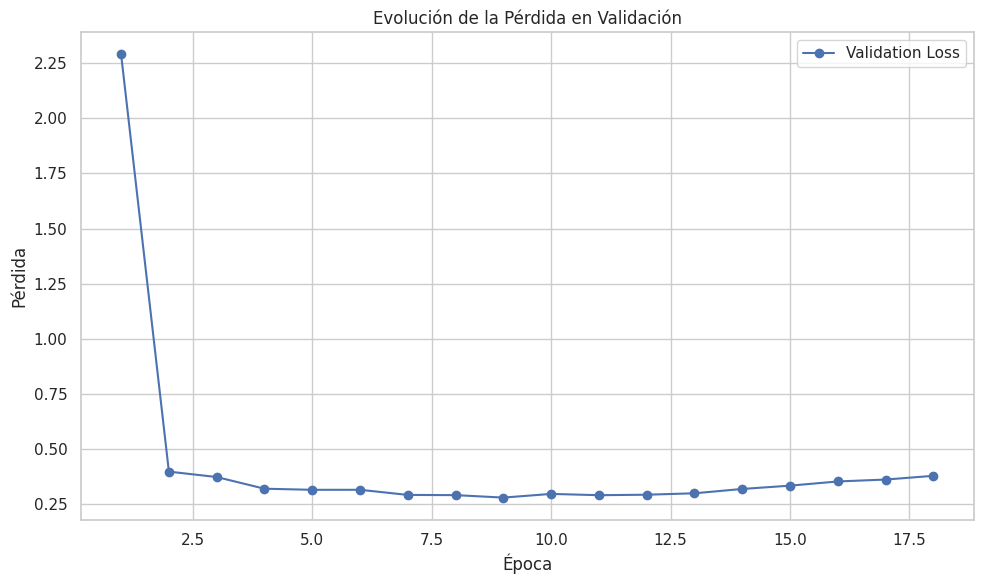

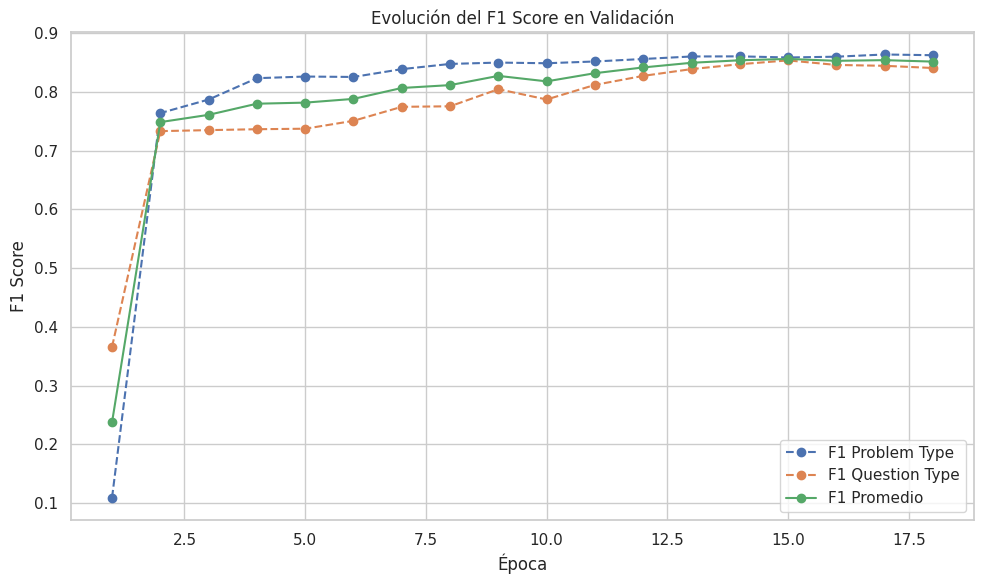

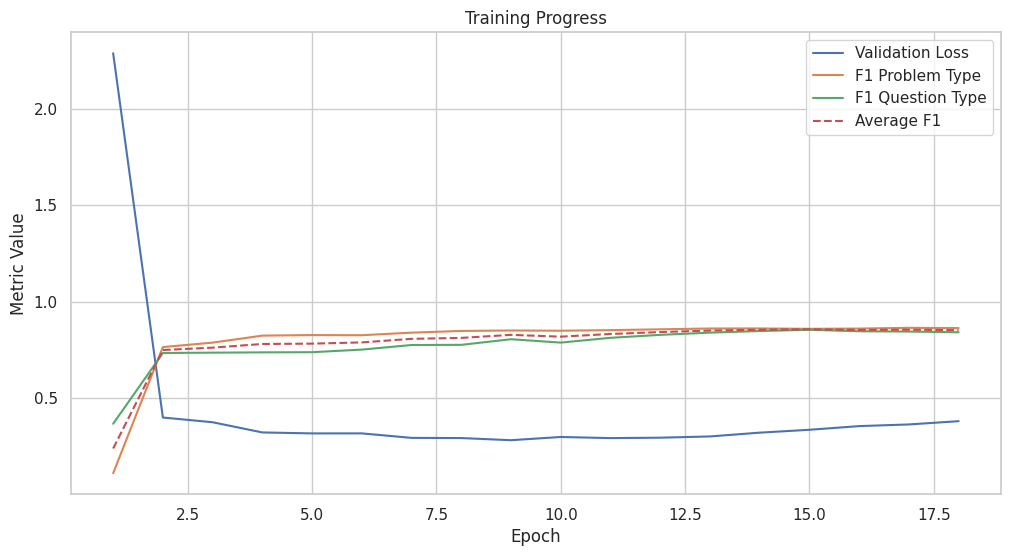


Mejores métricas obtenidas:
Época: 15.0
Validation Loss: 0.3347
F1 Problem Type: 0.8587
F1 Question Type: 0.8537
F1 Promedio: 0.8562


In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de los gráficos.
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Ruta del archivo con las métricas almacenadas (cámbiala según corresponda).
metrics_path = '/content/drive/MyDrive/tesis/categorizacion/train_metrics.pkl'

# Cargar las métricas guardadas.
with open(metrics_path, 'rb') as f:
    train_metrics = pickle.load(f)

# Convertir el diccionario en un DataFrame de pandas para mejor visualización.
df_metrics = pd.DataFrame(train_metrics)

# Mostrar la tabla de métricas por época.
print("Resumen de métricas por época:")
print(df_metrics)

# --- Gráfico 1: Evolución de la Pérdida ---
plt.figure()
plt.plot(df_metrics['epoch'], df_metrics['train_loss'], marker='o', color='b', label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida en Validación')
plt.legend()
plt.tight_layout()
plt.show()

# --- Gráfico 2: Evolución de los F1 Score ---
plt.figure()
plt.plot(df_metrics['epoch'], df_metrics['f1_problem'], marker='o', linestyle='--', label='F1 Problem Type')
plt.plot(df_metrics['epoch'], df_metrics['f1_question'], marker='o', linestyle='--', label='F1 Question Type')
plt.plot(df_metrics['epoch'], df_metrics['avg_f1'], marker='o', linestyle='-', label='F1 Promedio')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.title('Evolución del F1 Score en Validación')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visualización de métricas de entrenamiento ---
plt.figure(figsize=(12, 6))
plt.plot(train_metrics['epoch'], train_metrics['train_loss'], label='Validation Loss')
plt.plot(train_metrics['epoch'], train_metrics['f1_problem'], label='F1 Problem Type')
plt.plot(train_metrics['epoch'], train_metrics['f1_question'], label='F1 Question Type')
plt.plot(train_metrics['epoch'], train_metrics['avg_f1'], label='Average F1', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# --- Tabla Resumen: Mejor Época y Métricas Correspondientes ---
best_epoch_idx = df_metrics['avg_f1'].idxmax()
best_metrics = df_metrics.loc[best_epoch_idx]

print("\nMejores métricas obtenidas:")
print(f"Época: {best_metrics['epoch']}")
print(f"Validation Loss: {best_metrics['train_loss']:.4f}")
print(f"F1 Problem Type: {best_metrics['f1_problem']:.4f}")
print(f"F1 Question Type: {best_metrics['f1_question']:.4f}")
print(f"F1 Promedio: {best_metrics['avg_f1']:.4f}")


Resultados del Test:
avg_loss:
0.3820978879785587

accuracy_problem:
0.9263881672765059

accuracy_question:
0.9904047047899095

f1_problem:
0.8593522078104022

f1_question:
0.8494502668696655

confusion_matrix_problem:
[[37152   246    95   530   394   179   400    87]
 [  333  3977     1    24    16     4     3    19]
 [  123     3  7226   171    13   211   256    35]
 [  518    21   134 20721    45    32    40     8]
 [  335    18     9    53  4635    11    44     4]
 [  317     6   204    48    21  2127   157    84]
 [  603    10   217    73    38   129  7493    27]
 [  130    13    40    17     6    74    30   471]]

confusion_matrix_question:
[[25090    42     1     2]
 [   59 50956    11   325]
 [    3    43    23     2]
 [   12   368     0 13524]]

Tabla resumen de métricas:
             Métrica     Valor
0               Loss  0.382098
1   Accuracy Problem  0.926388
2  Accuracy Question  0.990405
3         F1 Problem  0.859352
4        F1 Question  0.849450


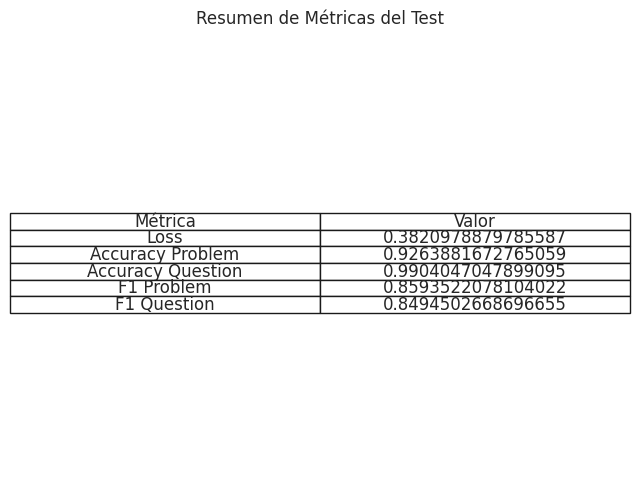

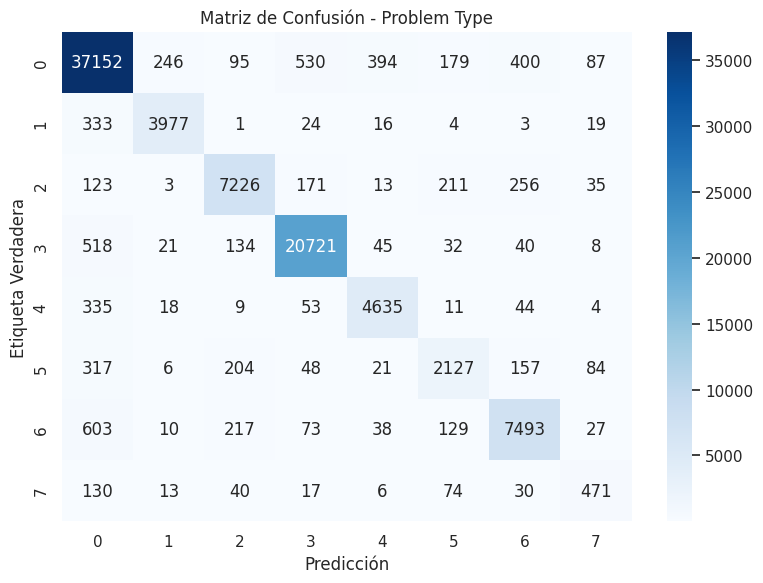

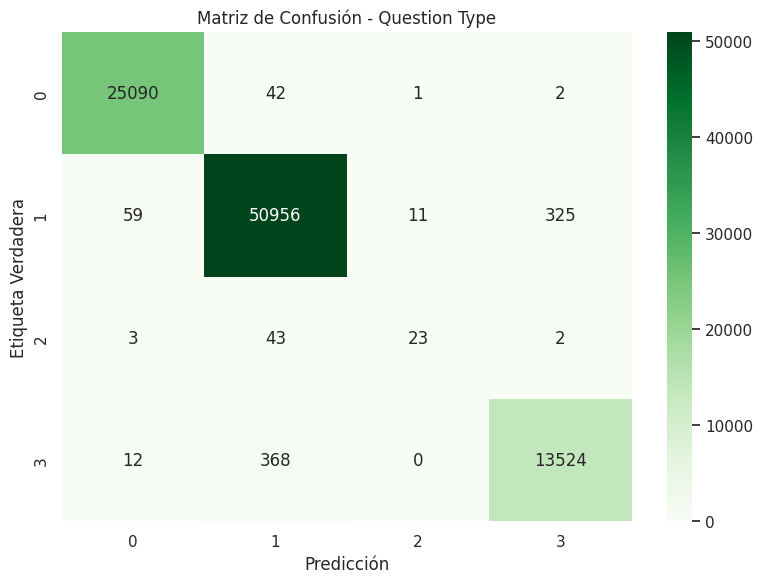

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de estilo para los gráficos.
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# Ruta del archivo donde se guardaron los resultados del test.
results_path = '/content/drive/MyDrive/tesis/categorizacion/test_results.pkl'

# Cargar el diccionario de resultados del test.
with open(results_path, 'rb') as f:
    test_results = pickle.load(f)

# Mostrar en consola el diccionario de resultados.
print("Resultados del Test:")
for key, value in test_results.items():
    print(f"{key}:")
    print(value)
    print()

# --- Tabla Resumen de Métricas ---
# Se crea un DataFrame a partir de las métricas escalar para una visualización tabular.
summary_data = {
    "Métrica": ["Loss", "Accuracy Problem", "Accuracy Question", "F1 Problem", "F1 Question"],
    "Valor": [
        test_results["avg_loss"],
        test_results["accuracy_problem"],
        test_results["accuracy_question"],
        test_results["f1_problem"],
        test_results["f1_question"]
    ]
}
df_summary = pd.DataFrame(summary_data)
print("Tabla resumen de métricas:")
print(df_summary)

# --- Gráfico: Tabla Resumen ---
# Mostramos la tabla resumen en un gráfico (opcional)
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.title("Resumen de Métricas del Test")
plt.show()

# --- Gráfico: Matriz de Confusión para 'problem_type' ---
cm_problem = test_results["confusion_matrix_problem"]
plt.figure()
sns.heatmap(cm_problem, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión - Problem Type")
plt.tight_layout()
plt.show()

# --- Gráfico: Matriz de Confusión para 'question_type' ---
cm_question = test_results["confusion_matrix_question"]
plt.figure()
sns.heatmap(cm_question, annot=True, fmt='d', cmap="Greens")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión - Question Type")
plt.tight_layout()
plt.show()


### Inferencia con pipeline

In [ ]:
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 30.8 MB/s eta 0:00:00


In [ ]:
import re
import pickle

def preprocess_function(example, tokenizer, seq_len):
    text = example["problem"].lower()
    # Conservar operadores y puntuación matemática relevante
    text = re.sub(r"[^\w\d\s\+\-\*/=^√%.,()]", " ", text)
    # Normalizar repeticiones de 'x' largas
    text = re.sub(r'\b[x]{2,}\b', 'x', text)
    text = re.sub(' +', ' ', text)

    tokens = tokenizer(text, padding="max_length", max_length=seq_len, truncation=True)
    return tokens

# Funciones para guardar y cargar objetos con pickle
def save_file(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

def load_file(name):
    return pickle.load(open(name, "rb"))

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import pickle
import re

class BertMultiTaskClassifier(nn.Module):
    def __init__(self, dropout, num_problem_types, num_question_types):
        super(BertMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.classifier_problem = nn.Linear(768, num_problem_types)
        self.classifier_question = nn.Linear(768, num_question_types)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]
        x = self.dropout(pooled_output)
        x = self.activation(x)
        logits_problem = self.classifier_problem(x)
        logits_question = self.classifier_question(x)
        return logits_problem, logits_question


class MultiTaskInferencePipeline:
    def __init__(self, model_path, encoder_problem_path, encoder_question_path, dropout=0.5):
        self.preprocess_function = preprocess_function  # Guardamos la función

        with open(encoder_problem_path, "rb") as f:
            self.le_problem = pickle.load(f)
        with open(encoder_question_path, "rb") as f:
            self.le_question = pickle.load(f)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        self.model = BertMultiTaskClassifier(dropout, len(self.le_problem.classes_), len(self.le_question.classes_))
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, text):
        # Preprocesar usando la misma función que durante el entrenamiento
        example = {"problem": text}
        encoded = self.preprocess_function(example, self.tokenizer, seq_len=512)

        input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(self.device)
        attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(self.device)

        with torch.no_grad():
            logits_problem, logits_question = self.model(input_ids, attention_mask)
            pred_problem = torch.argmax(logits_problem, dim=1).cpu().numpy()[0]
            pred_question = torch.argmax(logits_question, dim=1).cpu().numpy()[0]

        label_problem = self.le_problem.inverse_transform([pred_problem])[0]
        label_question = self.le_question.inverse_transform([pred_question])[0]

        return {
            "problem_type": label_problem,
            "question_type": label_question
        }

In [ ]:
model_path="/content/drive/MyDrive/tesis/categorizacion/bert_pre_trained_math_f1.pth"
problem_type_encoder_path="/content/drive/MyDrive/tesis/categorizacion/problem_type_encoder.pkl"
question_type_encoder_path="/content/drive/MyDrive/tesis/categorizacion/question_type_encoder.pkl"

In [ ]:
pipeline = MultiTaskInferencePipeline(
    model_path= model_path,
    encoder_problem_path=problem_type_encoder_path,
    encoder_question_path=question_type_encoder_path
)

resultado = pipeline.predict("What is the integral of x squared from 0 to 1?")
print(f"Problem Type: {resultado['problem_type']}")
print(f"Question Type: {resultado['question_type']}")

Problem Type: Calculus
Question Type: math-word-problem
